In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
%matplotlib inline

from collections import namedtuple
from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sys
sys.path.append('/home/ryohayama/python_current/BasicFeatureAnalysis')

import feature as F
import feature_collection as FC

In [3]:
import ps.joint_probability as psjp

In [4]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]

binary_fs = sorted([f for f in all_fs if '_bin' in f])

categorical_fs = sorted([f for f in all_fs if '_cat' in f])

other_fs = sorted([f for f in all_fs
                if f not in binary_fs
                if f not in categorical_fs])

target = train.target

In [5]:
train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [6]:
used_fs = other_fs.copy()
used_fs.remove('ps_calc_01')
used_fs.remove('ps_calc_02')
used_fs.remove('ps_calc_03')
used_fs.remove('ps_calc_04')
used_fs.remove('ps_calc_06')
used_fs.remove('ps_calc_08')
used_fs.remove('ps_calc_09')

In [7]:
conts = train[used_fs + ['target']]
conts.columns

Index(['ps_calc_05', 'ps_calc_07', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12',
       'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14',
       'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'target'],
      dtype='object')

In [8]:
conts.shape

(595212, 20)

In [9]:
conts = conts.replace({-1:np.NaN}).dropna()

In [10]:
conts.shape

(453046, 20)

In [11]:
y = np.array(conts.target)
y.shape

(453046,)

# Pairwise Plot of Continuous Features

In [12]:
feature_pair_list = list(combinations(used_fs, 2))

In [13]:
pair_list1 = feature_pair_list[:90]
pair_list2 = feature_pair_list[90:]

## KernelPCA space

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

In [53]:
scaler = RobustScaler()
X = scaler.fit_transform(np.array(conts[used_fs]))

In [54]:
list_ = [i for i in range(X.shape[1])]
pca_pair_list = list(combinations(list_, 2))
pca_pair_list1 = pca_pair_list[:95]
pca_pair_list2 = pca_pair_list[95:]
print(len(pca_pair_list1))
print(len(pca_pair_list2))

95
76


In [84]:
num_sample = 5000
pca = KernelPCA(kernel='rbf', degree=4, gamma=1, n_jobs=6)
Xkpca = pca.fit_transform(X[:num_sample, :])

pca_labels = [('component_' + str(i)) for i in range(Xkpca.shape[1])]
conts_pca = pd.DataFrame(Xkpca, columns=pca_labels)

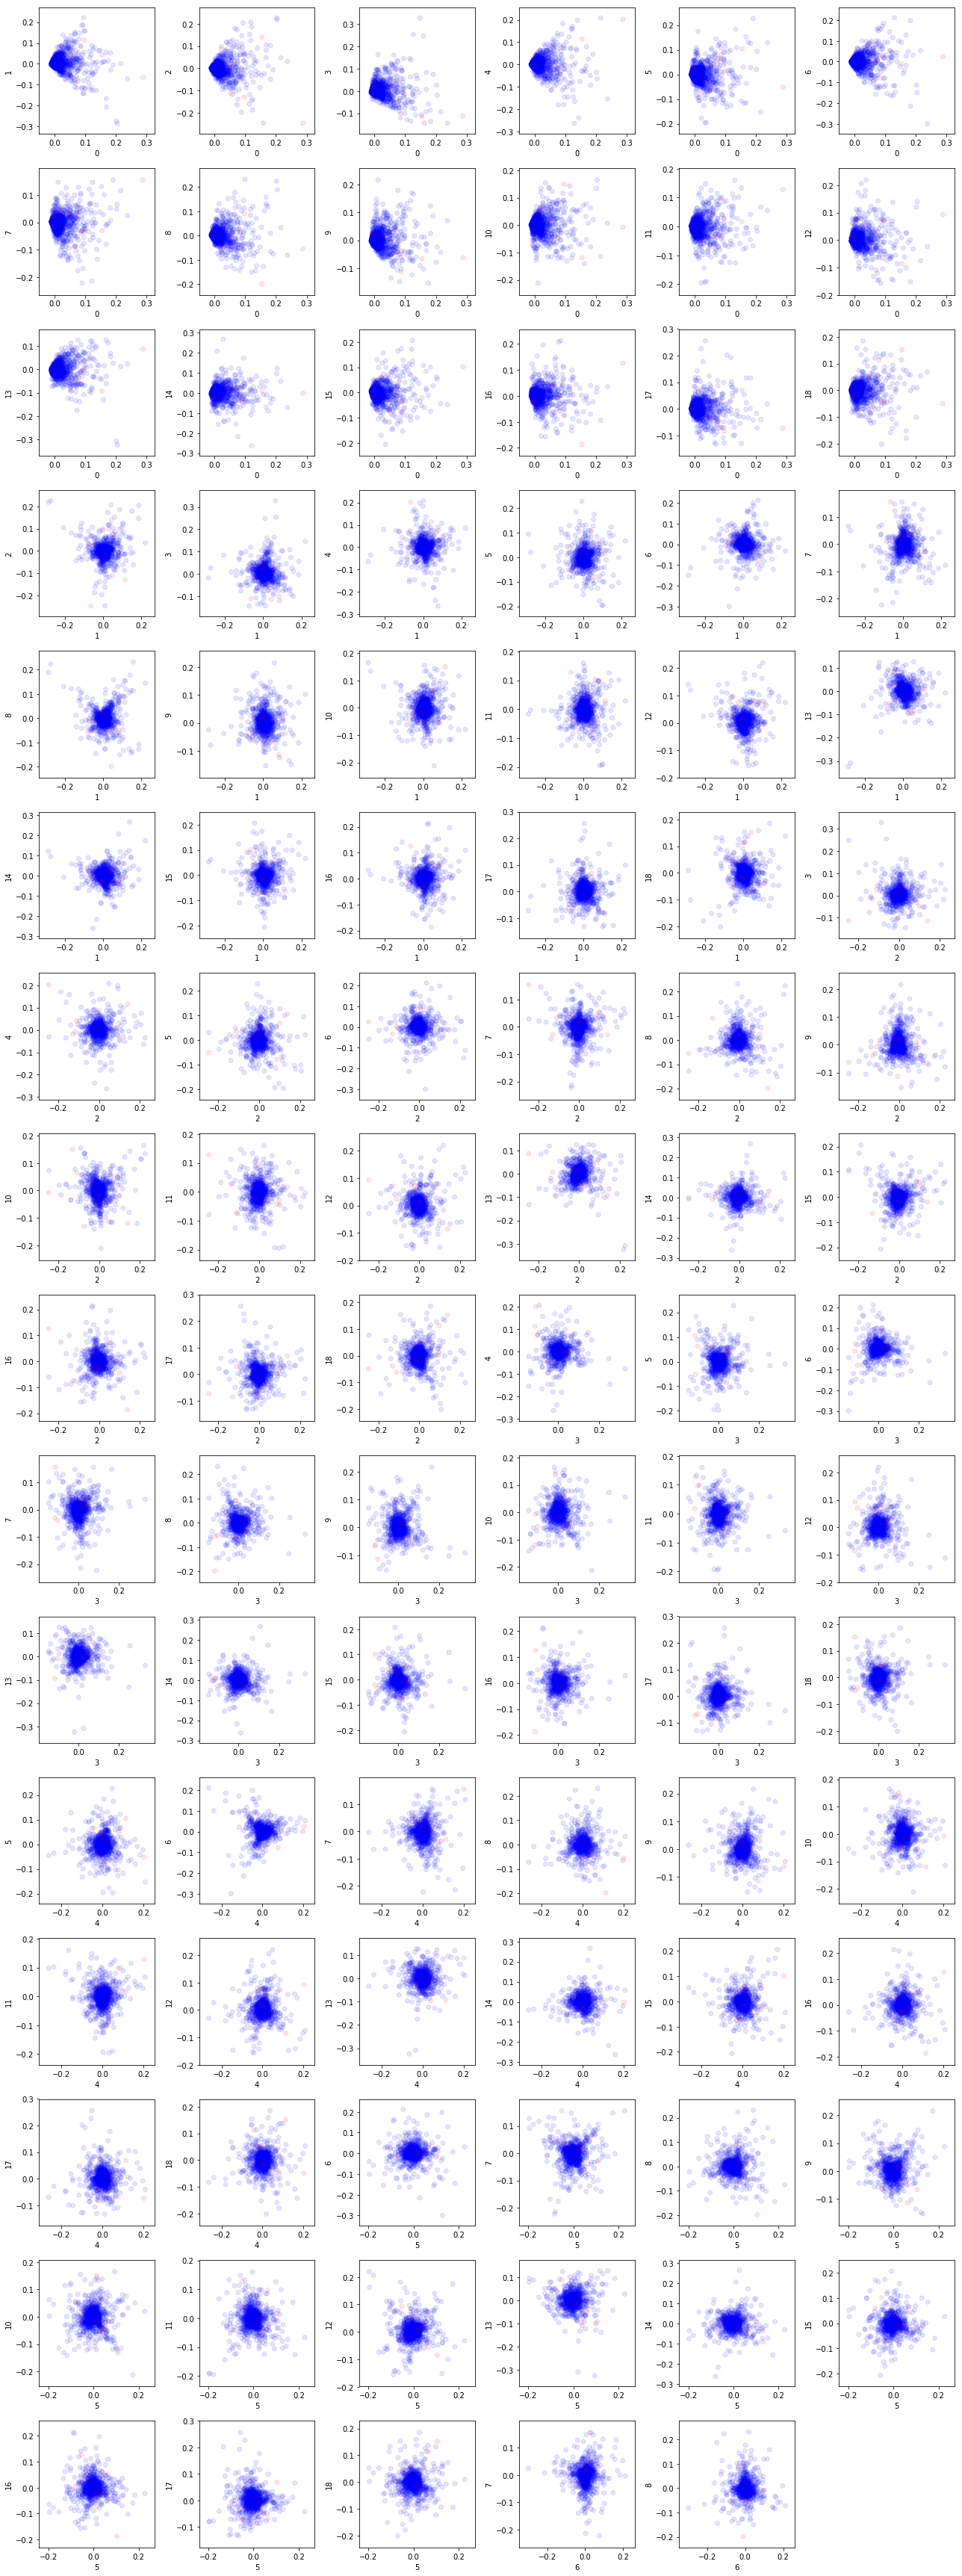

In [85]:
fig = plt.figure(figsize=(18, 48))
for i, pair in enumerate(pca_pair_list1):
    x0 = Xkpca[:, pair[0]]
    x1 = Xkpca[:, pair[1]]
    
    ax = fig.add_subplot(16, 6, i+1)
    ax.scatter(x0, x1, c=y[:num_sample], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()

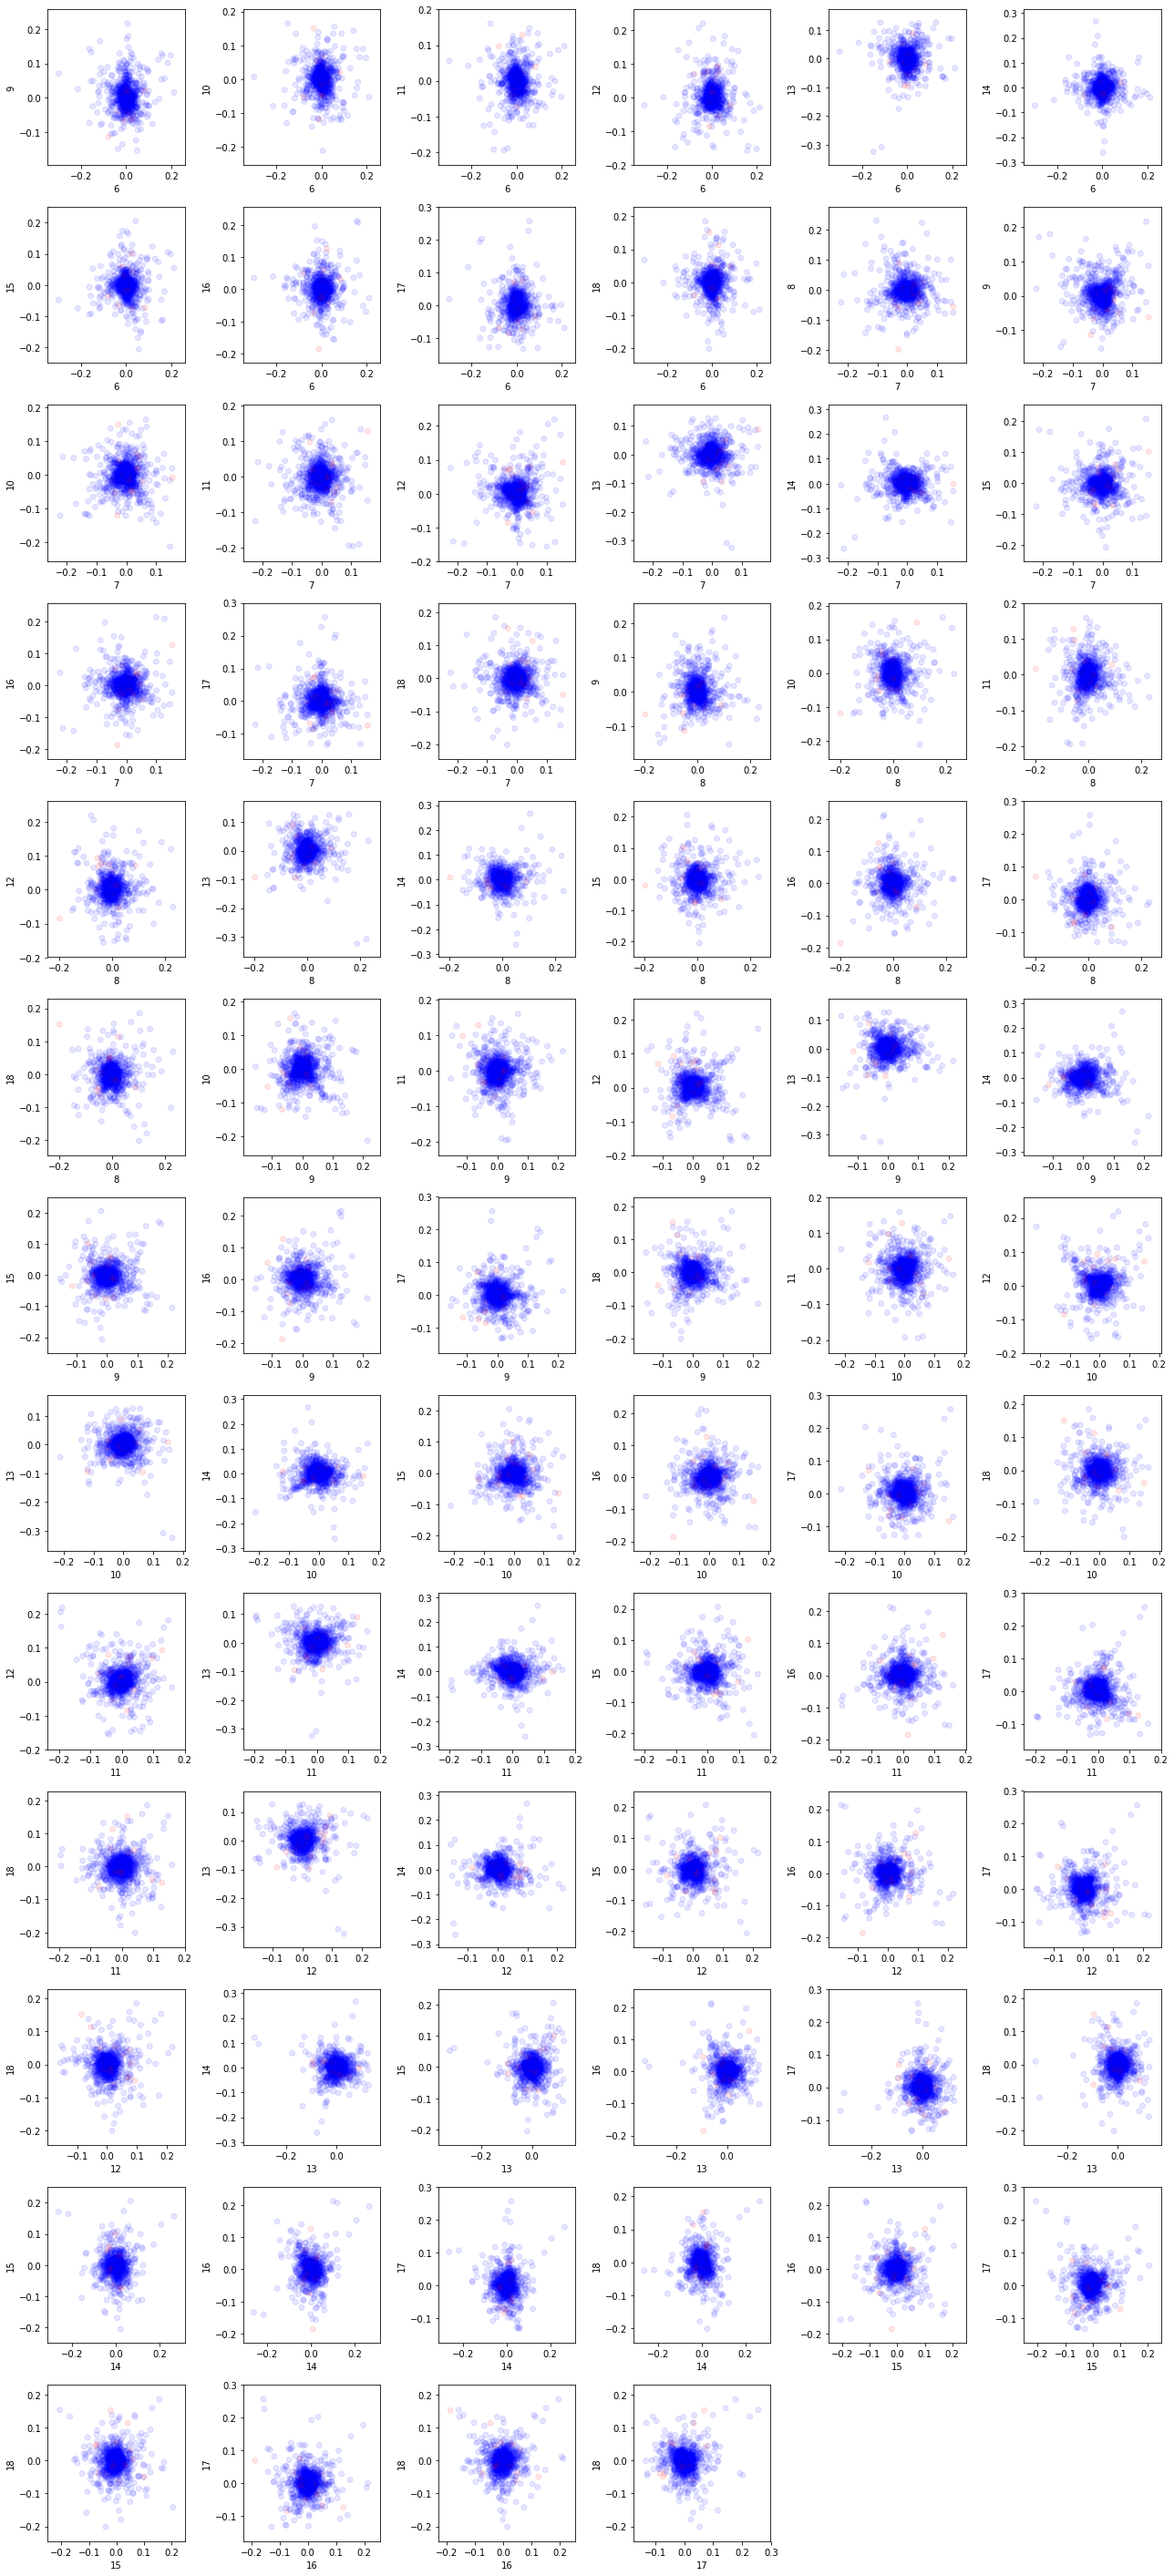

In [86]:
fig = plt.figure(figsize=(18, 48))
for i, pair in enumerate(pca_pair_list2):
    x0 = Xkpca[:, pair[0]]
    x1 = Xkpca[:, pair[1]]
    
    ax = fig.add_subplot(16, 6, i+1)
    ax.scatter(x0, x1, c=y[:num_sample], cmap=cm.bwr, alpha=0.1)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
plt.tight_layout()